In [5]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

In [6]:
src = "/home/andres/repos/rat-mapping-paper/reports/L_CIRC/inference.pkl"

with open(src, "rb") as f:
    df, encoder_dict, model, posterior_samples, = pickle.load(f)


# prediction_df = model.make_prediction_dataset(df=df, min_intensity=0., max_intensity=500.)
# posterior_predictive = model.predict(
#     df=prediction_df, posterior_samples=posterior_samples
# )


In [7]:
# a = posterior_samples[site.a]
# b = posterior_samples[site.b]
# L = posterior_samples[site.L]
# ell = posterior_samples[site.ell]
# H = posterior_samples[site.H]

# x = np.linspace(0, 500, 1000)

named_params = [site.a, site.b, site.L, site.ell, site.H]
params = [posterior_samples[param][:400, ...] for param in named_params]

for named_param, param in zip(named_params, params):
    print(named_param, param.shape)





a (400, 8, 21, 6)
b (400, 8, 21, 6)
L (400, 8, 21, 6)
ℓ (400, 8, 21, 6)
H (400, 8, 21, 6)


In [8]:
src = os.path.join("/home/andres/repos/rat-mapping-paper/reports/L_CIRC/predictions.pkl")

with open(src, "rb") as f:
    x, _, subjects, compound_positions, configurations, response, = pickle.load(f)


In [9]:
norm_y = []
norm_x = []

for subject_ind, subject in enumerate(subjects):
    curr_params = [
        param[:, subject_ind, :, :][:, :, :, None] for param in params
    ]
    constant = curr_params[0].mean()

    x_temp = np.linspace(0., 5 * constant, 500)
    x_temp = x_temp[None, None, None, :]

    temp_thresh = F.rectified_logistic(
        x_temp,
        *curr_params
    )
    norm_y.append(temp_thresh)
    norm_x.append(x_temp)

norm_y = np.array(norm_y)
norm_x = np.array(norm_x)

print(norm_y.shape)
print(norm_x.shape)

norm_y = np.swapaxes(norm_y, 1, 2)
norm_x = np.swapaxes(norm_x, 1, 2)
print()
print(norm_y.shape)
print(norm_x.shape)


(8, 400, 21, 6, 500)
(8, 1, 1, 1, 500)

(8, 21, 400, 6, 500)
(8, 1, 1, 1, 500)


In [10]:
def get_entropy(subset):
    y = norm_y[:, subset, ...]
    x = norm_x[:, :, 0, 0, :]

    y_max = ma.max(y, axis=(1, -1), keepdims=True) 
    y_max.shape

    y = ma.where(y, y / y_max, 0.)
    y.shape

    p = ma.sum(y, axis=-2, keepdims=True)
    p = ma.where(y, y / p, 0.)
    p.shape

    plogp = ma.where(p, p * ma.log(p), 0.)
    plogp.shape

    entropy = ma.where(
        ma.any(p, axis=-2, keepdims=True),
        (
            1
            + (ma.sum(plogp, axis=-2, keepdims=True) / np.log(plogp.shape[-2]))
        ),
        0.
    )
    entropy = entropy[..., 0, :]
    entropy.shape

    return entropy, x


In [11]:
vertices = [(i, cpos) for i, cpos in enumerate(compound_positions) if cpos.split("-")[0] == ""]
radii = [(i, cpos) for i, cpos in enumerate(compound_positions) if cpos.split("-")[0] and cpos.split("-")[1] == "C6LC"]
diameters = [(i, cpos) for i, cpos in enumerate(compound_positions) if (i, cpos) not in vertices and (i, cpos) not in radii]

vertices = [i for (i, cpos) in vertices]
radii = [i for (i, cpos) in radii]
diameters = [i for (i, cpos) in diameters]



In [32]:
compound_positions[10]

'C6LE-C6LW'

In [15]:
entropy, x = get_entropy(diameters)


(8, 1, 500)

In [25]:
entropy.shape

(8, 4, 400, 500)

In [42]:
x.shape

(8, 1, 500)

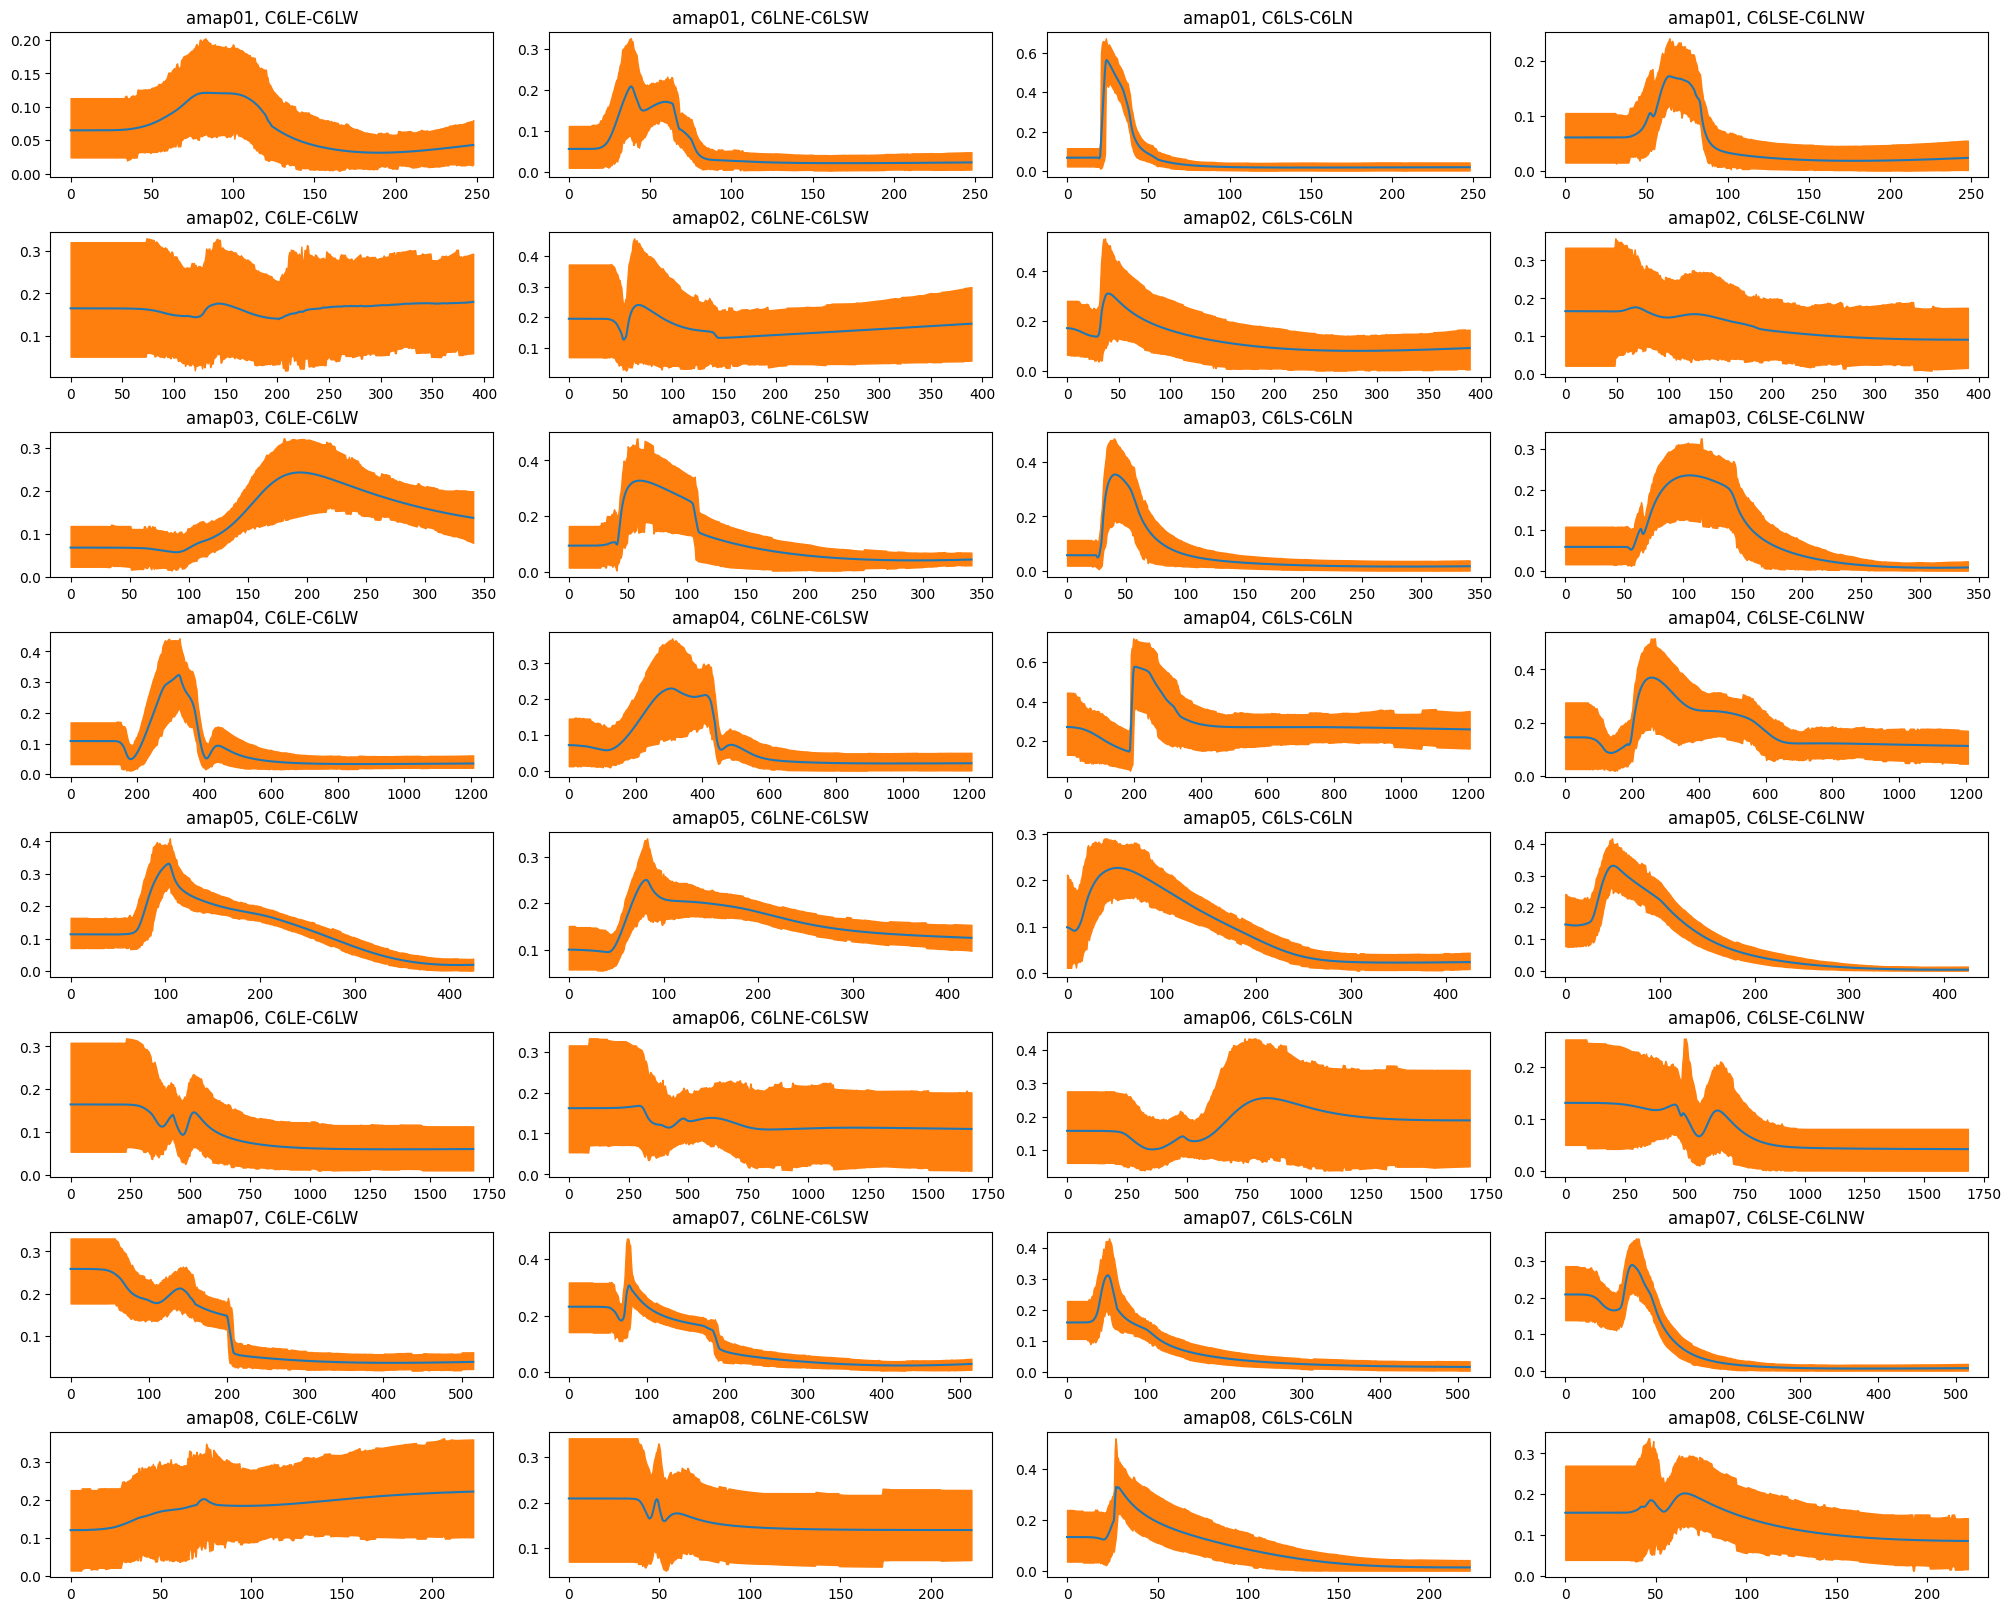

In [54]:
nrows, ncols = len(subjects), len(entropy[0,:,0,0])
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, constrained_layout=True, squeeze=False, figsize=(ncols * 5, nrows * 2)
)

if len(entropy[0,:,0,0]) == 4: 
    configuration = diameters
elif len(entropy[0,:,0,0]) == 8:
    configuration = vertices
else:
    configuration = radii
    
for subject_ind, subject in enumerate(subjects):
    j = 0
    for cpos_ind in range(len(entropy[0,:,0,0])):
        cpos = compound_positions[configuration[cpos_ind]]
        ax = axes[subject_ind, j]
        samples = entropy[subject_ind, cpos_ind, :, :]
        samples_mean = samples.mean(axis=0)
        
        samples_hdi = hpdi(samples, 0.95, axis=0)
        x_temp = x[subject_ind, 0, ...].tolist()
        
        sns.lineplot(x=x_temp, y=samples_mean, ax=ax)
        ax.fill_between(x_temp, samples_hdi[0, :], samples_hdi[1, :], color="C1")
        ax.set_title(f"{subject}, {cpos}")
        j += 1

In [55]:
entropy.shape

(8, 4, 400, 500)

In [56]:
area_list = []
for subject_ind, subject in enumerate(subjects):

    for cpos_ind in range(len(entropy[0,:,0,0])):
        cpos = compound_positions[configuration[cpos_ind]]
        x_temp = x[subject_ind, 0, ...].tolist()
        
        sample_integrals = entropy[subject_ind, cpos_ind, :, :]
        sample_integrals_mean = sample_integrals.mean(axis=0)
        
        area = np.trapz(sample_integrals_mean, x_temp)
        area_list.append((subject, cpos, area))

filt_positions = list(set((a[1] for a in area_list)))

In [261]:
for a in area_list:
    

[('amap01', 'C6LE-C6LW', 15.96594900983375),
 ('amap01', 'C6LNE-C6LSW', 13.01326858967598),
 ('amap01', 'C6LS-C6LN', 15.222720688229243),
 ('amap01', 'C6LSE-C6LNW', 12.07868787527365),
 ('amap02', 'C6LE-C6LW', 63.99218131584766),
 ('amap02', 'C6LNE-C6LSW', 64.55238276826333),
 ('amap02', 'C6LS-C6LN', 48.718544658512414),
 ('amap02', 'C6LSE-C6LNW', 49.2411671615223),
 ('amap03', 'C6LE-C6LW', 48.71041735868031),
 ('amap03', 'C6LNE-C6LSW', 38.16423178459952),
 ('amap03', 'C6LS-C6LN', 21.16089470562928),
 ('amap03', 'C6LSE-C6LNW', 26.508245790735096),
 ('amap04', 'C6LE-C6LW', 97.07403889958346),
 ('amap04', 'C6LNE-C6LSW', 84.63078648545007),
 ('amap04', 'C6LS-C6LN', 346.9057137846439),
 ('amap04', 'C6LSE-C6LNW', 204.94063704661303),
 ('amap05', 'C6LE-C6LW', 54.00249043357573),
 ('amap05', 'C6LNE-C6LSW', 67.2242355169817),
 ('amap05', 'C6LS-C6LN', 38.279723513162935),
 ('amap05', 'C6LSE-C6LNW', 37.946704073058996),
 ('amap06', 'C6LE-C6LW', 157.51088068761476),
 ('amap06', 'C6LNE-C6LSW', 212

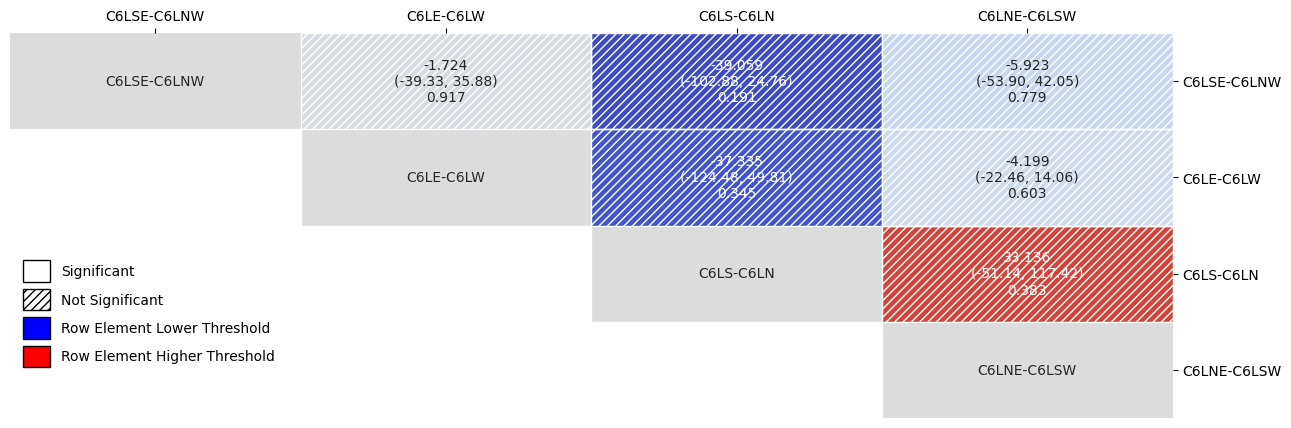

In [60]:
pvalues = []
means = []
lab = []
labels = []

for pos_ind_one, p_one in enumerate(filt_positions):    
    for pos_ind_two, p_two in enumerate(filt_positions):         
        if pos_ind_one == pos_ind_two:
            pvalues.append((0))
            lab.append(p_one)
            means.append(0)
            labels.append(p_one)
            continue
        group_one = np.array(list(a[2] for a in area_list if a[1] == p_one))
        group_two = np.array(list(a[2] for a in area_list if a[1] == p_two))
        ttest = stats.ttest_rel(group_one, group_two, alternative='two-sided')
        pvalues.append(ttest.pvalue)
        ci = ttest.confidence_interval(.95)
        # pvalues.append((p_one, p_two, f"{stats.ttest_rel(group_one, group_two, alternative='two-sided')[1]}"))
        t = group_one - group_two
        means.append(t.mean())
        lab.append(f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})\n{ttest.pvalue:.3f}")

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(4,4)

means = np.array(means)
means = means.reshape(4,4)

lab = np.array(lab)
lab = lab.reshape(4,4)
# unique_pvalues = set(tuple(sorted(t)) for t in pvalues)

mask = np.tril(np.ones_like(means), k=-1)
# mask = np.tril(np.ones_like(mask), k=-1)
plt.figure(figsize=(15, 5))
ax =sns.heatmap(means, xticklabels= labels, annot = lab, yticklabels= labels, mask = mask, fmt = "", cbar = False,center = 0, cmap = "coolwarm")

hatch_mask = pvalues > 0.1
handles = []

for i in range (pvalues.shape[0]):
  for j in range(pvalues.shape[1]):
      if hatch_mask[i, j]:
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='', label="Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='////', label="Not Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                    hatch='', label="Row Element Lower Threshold"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                    hatch='', label="Row Element Higher Threshold"))
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
          handlelength=2, handleheight=2, frameon=False)
ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

ax.yaxis.tick_right()
plt.show()

In [67]:
vertices = [(i, cpos) for i, cpos in enumerate(compound_positions) if cpos.split("-")[0] == ""]
radii = [(i, cpos) for i, cpos in enumerate(compound_positions) if cpos.split("-")[0] and cpos.split("-")[1] == "C6LC"]
diameters = [(i, cpos) for i, cpos in enumerate(compound_positions) if (i, cpos) not in vertices and (i, cpos) not in radii]

vertices = [i for (i, cpos) in vertices]
radii = [i for (i, cpos) in radii]
diameters = [i for (i, cpos) in diameters]

In [156]:
def graph_entropy_heatmap(config):   
    global compound_positions 
    
    func_entrop, x_val = get_entropy(config)
    
    area_list = []
    
    if len(func_entrop[0,:,0,0]) == 4: 
        configuration = diameters
    elif len(func_entrop[0,:,0,0]) == 8:
        configuration = radii
    else:
        configuration = vertices
        
    for subject_ind, subject in enumerate(subjects):

        for cpos_ind in range(len(func_entrop[0,:,0,0])):
            cpos = compound_positions[configuration[cpos_ind]]
            x_temp = x_val[subject_ind, 0, ...].tolist()
            
            sample_integrals = func_entrop[subject_ind, cpos_ind, :, :]
            sample_integrals_mean = sample_integrals.mean(axis=0)
            
            area = np.trapz(sample_integrals_mean, x_temp)
            area_list.append((subject, cpos, area))

    filt_positions = list(set((a[1] for a in area_list)))

    pvalues = []
    means = []
    annot = []
    labels = []
    ind_mean_values = []

    for pos_ind_one, p_one in enumerate(filt_positions):    
        for pos_ind_two, p_two in enumerate(filt_positions):         
            if pos_ind_one == pos_ind_two:
                pvalues.append((0))
                annot.append(p_one)
                means.append(0)
                labels.append(p_one)
                indiv = np.array(list(a[2] for a in area_list if a[1] == p_one))
                ind_mean_values.append(indiv.mean())
                continue
            group_one = np.array(list(a[2] for a in area_list if a[1] == p_one))
            group_two = np.array(list(a[2] for a in area_list if a[1] == p_two))

            ttest = stats.ttest_rel(group_one, group_two, alternative='two-sided')
            pvalues.append(ttest.pvalue)
            ci = ttest.confidence_interval(.95)
            t = group_one - group_two
            means.append(t.mean())
            annot.append(f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})\n{ttest.pvalue:.3f}")

    pvalues = np.array(pvalues)
    ret_pvalues = pvalues
    pvalues = pvalues.reshape(len(func_entrop[0,:,0,0]),len(func_entrop[0,:,0,0]))

    means = np.array(means)
    means = means.reshape(len(func_entrop[0,:,0,0]),len(func_entrop[0,:,0,0]))

    annot = np.array(annot)
    annot = annot.reshape(len(func_entrop[0,:,0,0]),len(func_entrop[0,:,0,0]))

    mask = np.tril(np.ones_like(means), k=-1)

    plt.figure(figsize=(15, 5))
    ax =sns.heatmap(means, xticklabels= labels, annot = annot, yticklabels= labels, mask = mask, fmt = "", cbar = False,center = 0, cmap = "coolwarm")

    hatch_mask = pvalues > 0.1
    handles = []

    for i in range (pvalues.shape[0]):
        for j in range(pvalues.shape[1]):
            if hatch_mask[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                        hatch='', label="Significant"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                        hatch='////', label="Not Significant"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                        hatch='', label="Row Element Lower Threshold"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                        hatch='', label="Row Element Higher Threshold"))
    ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
            handlelength=2, handleheight=2, frameon=False)
    ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

    ax.yaxis.tick_right()
    
    if len(config) == 4:
        plt.title("Diameters")
        
    elif len(config) == 8:
        plt.title("Radii")
    else: 
        plt.title("Vertices")

    plt.show()
    
    return ind_mean_values, labels, ret_pvalues


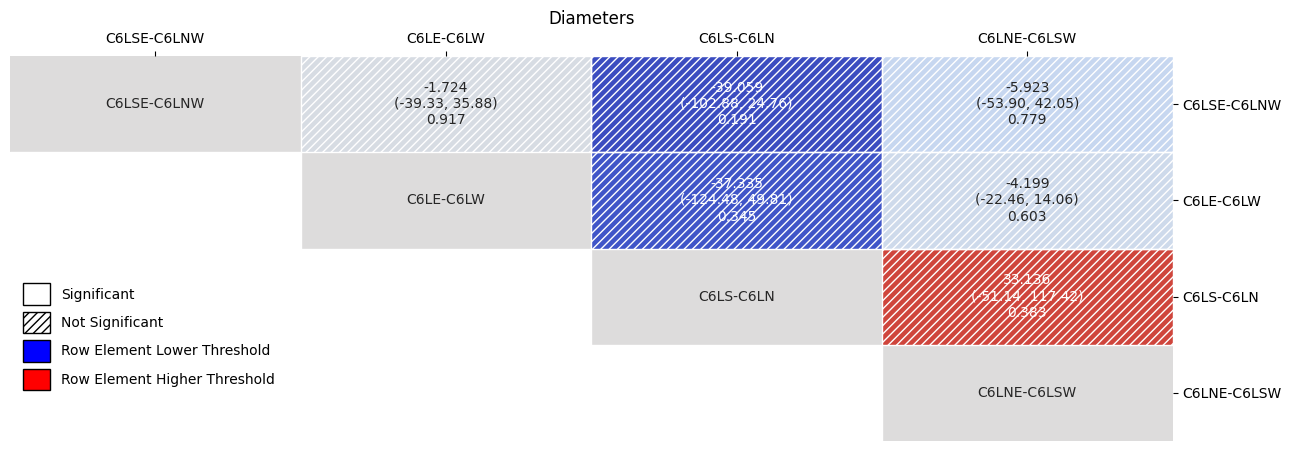

In [157]:
ind_mean_values, labels, pvalues = graph_entropy_heatmap(diameters)

In [158]:
circ_values = ind_mean_values + ind_mean_values

In [159]:
circ_labels = labels + labels

In [164]:
area_list = []
for subject_ind, subject in enumerate(subjects):

    for cpos_ind in range(len(entropy[0,:,0,0])):
        cpos = compound_positions[configuration[cpos_ind]]
        x_temp = x[subject_ind, 0, ...].tolist()
        
        sample_integrals = entropy[subject_ind, cpos_ind, :, :]
        sample_integrals_mean = sample_integrals.mean(axis=0)
        
        area = np.trapz(sample_integrals_mean, x_temp)
        area_list.append((subject, cpos, area))

filt_positions = list(set((a[1] for a in area_list)))

In [259]:
pvalues = []
means = []
lab = []
labels = []
graph_vals = []

for pos_ind_one, p_one in enumerate(filt_positions):    
    for pos_ind_two, p_two in enumerate(filt_positions):         
        if pos_ind_one == pos_ind_two:
            pvalues.append(0)
            means.append(0)
            labels.append(p_one)
            graph_vals.append((np.array(list(a[2] for a in area_list if a[1] == p_one)).mean()))
            continue
        group_one = np.array(list(a[2] for a in area_list if a[1] == p_one))
        group_two = np.array(list(a[2] for a in area_list if a[1] == p_two))
        ttest = stats.ttest_rel(group_one, group_two, alternative='two-sided')
        pvalues.append(ttest.pvalue)
        ci = ttest.confidence_interval(.95)
        # pvalues.append((p_one, p_two, f"{stats.ttest_rel(group_one, group_two, alternative='two-sided')[1]}"))
        t = group_one - group_two
        means.append(t.mean())
        labels.append((p_one, p_two))

pvalues = np.array(pvalues)
# pvalues = pvalues.reshape(4,4)

means = np.array(means)
# means = means.reshape(4,4)

# lab = lab.reshape(4,4)
# unique_pvalues = set(tuple(sorted(t)) for t in pvalues)

# mask = np.tril(np.ones_like(means), k=-1)
# # mask = np.tril(np.ones_like(mask), k=-1)
# plt.figure(figsize=(15, 5))
# ax =sns.heatmap(means, xticklabels= labels, annot = lab, yticklabels= labels, mask = mask, fmt = "", cbar = False,center = 0, cmap = "coolwarm")

# hatch_mask = pvalues > 0.1
# handles = []

# for i in range (pvalues.shape[0]):
#   for j in range(pvalues.shape[1]):
#       if hatch_mask[i, j]:
#         ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
# handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
#                     hatch='', label="Significant"))
# handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
#                     hatch='////', label="Not Significant"))
# handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
#                     hatch='', label="Row Element Lower Threshold"))
# handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
#                     hatch='', label="Row Element Higher Threshold"))
# ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
#           handlelength=2, handleheight=2, frameon=False)
# ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

# ax.yaxis.tick_right()
# plt.show()

In [263]:
area_list

[('amap01', 'C6LE-C6LW', 15.96594900983375),
 ('amap01', 'C6LNE-C6LSW', 13.01326858967598),
 ('amap01', 'C6LS-C6LN', 15.222720688229243),
 ('amap01', 'C6LSE-C6LNW', 12.07868787527365),
 ('amap02', 'C6LE-C6LW', 63.99218131584766),
 ('amap02', 'C6LNE-C6LSW', 64.55238276826333),
 ('amap02', 'C6LS-C6LN', 48.718544658512414),
 ('amap02', 'C6LSE-C6LNW', 49.2411671615223),
 ('amap03', 'C6LE-C6LW', 48.71041735868031),
 ('amap03', 'C6LNE-C6LSW', 38.16423178459952),
 ('amap03', 'C6LS-C6LN', 21.16089470562928),
 ('amap03', 'C6LSE-C6LNW', 26.508245790735096),
 ('amap04', 'C6LE-C6LW', 97.07403889958346),
 ('amap04', 'C6LNE-C6LSW', 84.63078648545007),
 ('amap04', 'C6LS-C6LN', 346.9057137846439),
 ('amap04', 'C6LSE-C6LNW', 204.94063704661303),
 ('amap05', 'C6LE-C6LW', 54.00249043357573),
 ('amap05', 'C6LNE-C6LSW', 67.2242355169817),
 ('amap05', 'C6LS-C6LN', 38.279723513162935),
 ('amap05', 'C6LSE-C6LNW', 37.946704073058996),
 ('amap06', 'C6LE-C6LW', 157.51088068761476),
 ('amap06', 'C6LNE-C6LSW', 212

In [288]:
bubble_angles[0:4]

[90, 45, 180, 135]

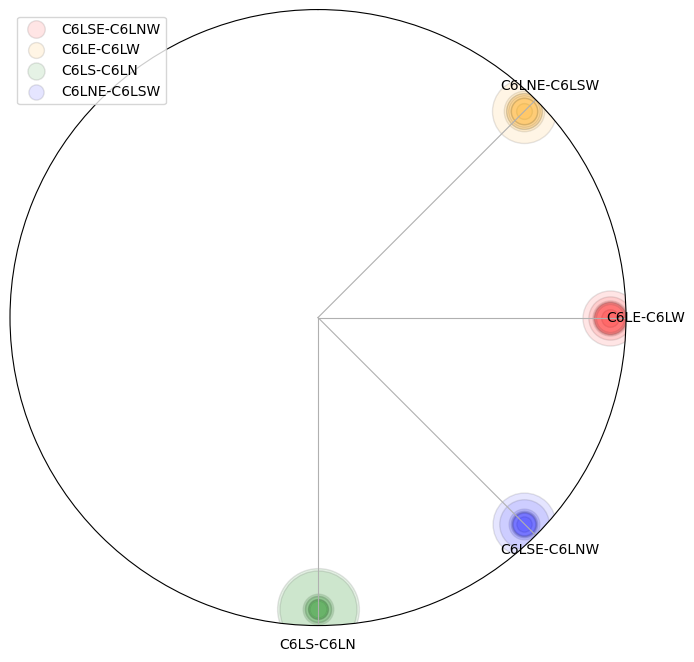

In [297]:
# Graph results with bubble plot
bubble_angles = [] 
for a in (area_list):
    if a[1] == 'C6LSE-C6LNW':
        bubble_angles.append(135)
    elif a[1] == 'C6LE-C6LW':
        bubble_angles.append(90)
    elif a[1] == 'C6LS-C6LN':
        bubble_angles.append(180)
    elif a[1] == 'C6LNE-C6LSW':
        bubble_angles.append(45)


color_map = {'C6LSE-C6LNW':'blue', 'C6LE-C6LW':'red', 'C6LS-C6LN':'green', 'C6LNE-C6LSW':'orange'}

bubble_rads = np.radians(bubble_angles)

bubble_sizes = 10

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
bubble_label = []
for i, a in enumerate(area_list):
    # ax.text(bubble_rads[i], .5, label, horizontalalignment='center', verticalalignment='center')
    ax.scatter(bubble_rads[i], 10,  #x = angle, y = radius
                s=area_list[i][2]*10,alpha=0.1, color= color_map[a[1]],edgecolors='black')

plt.legend(color_map.keys(), loc='upper left')
plt.xticks(bubble_rads[0:4], list((a[1] for a in area_list[0:4])))  
ax.set_yticklabels([])
ax.yaxis.set_visible(False)
plt.show()

In [296]:
list((a[1] for a in area_list[0:4]))

['C6LE-C6LW', 'C6LNE-C6LSW', 'C6LS-C6LN', 'C6LSE-C6LNW']

In [294]:
labels

['C6LSE-C6LNW',
 ('C6LSE-C6LNW', 'C6LE-C6LW'),
 ('C6LSE-C6LNW', 'C6LS-C6LN'),
 ('C6LSE-C6LNW', 'C6LNE-C6LSW'),
 ('C6LE-C6LW', 'C6LSE-C6LNW'),
 'C6LE-C6LW',
 ('C6LE-C6LW', 'C6LS-C6LN'),
 ('C6LE-C6LW', 'C6LNE-C6LSW'),
 ('C6LS-C6LN', 'C6LSE-C6LNW'),
 ('C6LS-C6LN', 'C6LE-C6LW'),
 'C6LS-C6LN',
 ('C6LS-C6LN', 'C6LNE-C6LSW'),
 ('C6LNE-C6LSW', 'C6LSE-C6LNW'),
 ('C6LNE-C6LSW', 'C6LE-C6LW'),
 ('C6LNE-C6LSW', 'C6LS-C6LN'),
 'C6LNE-C6LSW']

[('amap01', 'C6LE-C6LW', 15.96594900983375),
 ('amap01', 'C6LNE-C6LSW', 13.01326858967598),
 ('amap01', 'C6LS-C6LN', 15.222720688229243),
 ('amap01', 'C6LSE-C6LNW', 12.07868787527365),
 ('amap02', 'C6LE-C6LW', 63.99218131584766),
 ('amap02', 'C6LNE-C6LSW', 64.55238276826333),
 ('amap02', 'C6LS-C6LN', 48.718544658512414),
 ('amap02', 'C6LSE-C6LNW', 49.2411671615223),
 ('amap03', 'C6LE-C6LW', 48.71041735868031),
 ('amap03', 'C6LNE-C6LSW', 38.16423178459952),
 ('amap03', 'C6LS-C6LN', 21.16089470562928),
 ('amap03', 'C6LSE-C6LNW', 26.508245790735096),
 ('amap04', 'C6LE-C6LW', 97.07403889958346),
 ('amap04', 'C6LNE-C6LSW', 84.63078648545007),
 ('amap04', 'C6LS-C6LN', 346.9057137846439),
 ('amap04', 'C6LSE-C6LNW', 204.94063704661303),
 ('amap05', 'C6LE-C6LW', 54.00249043357573),
 ('amap05', 'C6LNE-C6LSW', 67.2242355169817),
 ('amap05', 'C6LS-C6LN', 38.279723513162935),
 ('amap05', 'C6LSE-C6LNW', 37.946704073058996),
 ('amap06', 'C6LE-C6LW', 157.51088068761476),
 ('amap06', 'C6LNE-C6LSW', 212